# Introduction to Neural Networks - PyTorch

Neural networks are a core component of deep learning, driving advancements in image recognition, natural language processing, robotics, and more. These networks are made up of interconnected layers that transform data through a series of operations, allowing them to learn complex patterns. At the heart of neural networks is the process of learning through gradients, calculated by *backpropagation* and the *chain rule*, which enables the network to adjust its parameters based on how much each parameter contributes to the overall error.

Modern deep learning frameworks like **PyTorch** and **TensorFlow** provide powerful abstractions for building and training neural networks, automatically handling gradient calculations and optimization steps. In this part of the assignment, we'll be using PyTorch!

In this part of the assignment, we will build a mini neural network framework that supports gradient propagation, allowing us to train a network on a real task and observe how it learns. Specifically, you will:

1. **Learn how to handle data inputs**: You will first implement some helper functions that will help you properly process input data and labels for training and evaluation. 
3. **Implement a Neural Network for Digit Classification (MNIST) using PyTorch**: After building a neural network to solve the XOR problem from scratch, you’ll implement another neural network in PyTorch to experience firsthand how these frameworks abstract many of the complex tasks involved in gradient calculations to solve a classic problem: the MNIST digit classification task. You will also get to tinker with your trained model to see how it performs on some drawings that you'll make!
3. **Train and Evaluate on the [Rig Juice](https://regularshow.fandom.com/wiki/Rig_Juice) Classification Task**: Finally, you will train both your custom implementation and the PyTorch version on a *Rig juice classification task*, exploring how each approach learns to classify samples of Rig juice based on a variety of features. This task will help you understand the practical differences between manual implementation and using a modern framework.

**Notes:**
- We've provided all the imports that you'll need for this assignment, though you're welcome to add imports _from the Python Standard Library only_ if you need them. If you want to add any helper functions for whatever reason, please make sure that they are nested inside the function that they are used in. This is to ensure that the autograder can run your code without any issues.
- ***DO NOT REMOVE ANY COMMENTS THAT HAVE `# export` IN THEM. THE GRADING SCRIPT USES THESE COMMENTS TO EVALUATE YOUR FUNCTIONS. WE WILL NOT AUDIT SUBMISSIONS TO ADD THESE. IF THE AUTOGRADER FAILS TO RUN DUE TO YOUR MODIFICATION OF THESE COMMENTS, YOU WILL NOT RECEIVE CREDIT.***


# Installations

In [37]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install torch
%pip install torchvision
%pip install gradio

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Imports

In [38]:
# export - DO NOT MODIFY THIS CELL
# General imports
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
from helpers import plot_loss
from PIL import Image
import gradio as gr

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from torchvision import datasets, transforms

In [39]:
# export - DO NOT MODIFY OR MOVE THIS LINE
# add any additional imports here (from the Python Standard Library only!)

# Neural Networks in PyTorch

Now that you have a solid foundation for understanding how the ins and outs of a neural network functions, in this section, we’ll use PyTorch (an industry-standard library) to create a neural network. PyTorch provides predefined layers, optimizers, and utilities that make network training more efficient and flexible.

This part of the assignment will allow you to explore the difference in setup and convenience between implementing a network from scratch and using a framework like PyTorch. Specifically, we'll be using PyTorch to implement neural networks to solve two different problems.

## Data Preparation

Before training our neural networks for either problem, we first have to prepare the data by shuffling it and splitting it into training and testing sets. 

The training set is used to train the model, allowing it to learn the underlying patterns and relationships within the data. In contrast, the testing set serves as a separate dataset that the model has not seen during training. This separation is critical for evaluating the model's performance and its ability to generalize. 

By using a testing set, we can assess how well the model can make predictions on new, unseen data, which is a key indicator of its effectiveness in real-world applications. Additionally, shuffling the data helps to ensure that the training and testing sets are representative of the overall dataset, reducing the risk of bias and improving the model.

Implement the below helper functions to load and prepare the data.

### Shuffling the Data

Shuffling ensures that the data is mixed randomly, which helps the model learn more effectively. 

Implement the below function to shuffle the data. Hint: You may find [torch.randperm](https://pytorch.org/docs/stable/generated/torch.randperm.html) useful for this function.

In [40]:
# export - DO NOT MODIFY OR MOVE THIS LINE
def shuffle_data(features: torch.Tensor, labels: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    '''
    Shuffle the features and labels of a dataset.
    Returns a tuple of shuffled features and shuffled labels.
    '''
    shuffled_features, shuffled_labels = None, None

    # YOUR CODE BELOW HERE
    p = torch.randperm(len(features))
    shuffled_features = features[p]
    shuffled_labels = labels[p]
    # YOUR CODE ABOVE HERE

    return shuffled_features, shuffled_labels

### Splitting the Data into Training and Testing Sets

Once the data is shuffled, we can split it into training and testing sets. The training set will be used to train the model, while the testing set will be used to evaluate its performance. The split ratio is typically 80% for training and 20% for testing. Though this is something you can tune, we've set this ratio for you to keep things simple. 

Implement the below helper function to split the data into training and testing sets.

In [41]:
# export - DO NOT MODIFY OR MOVE THIS LINE
def split_data(features: torch.Tensor, labels: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    '''
    Splits the data into a train and test set using
    the defined constant, TRAIN_TEST_SPLIT_RATIO. Please
    note that you *cannot* modify this constant.
    '''
    TRAIN_TEST_SPLIT_RATIO = 0.8
    train_features, train_labels = None, None
    test_features, test_labels = None, None

    # YOUR CODE BELOW HERE
    train_features = features[:int(len(features) * TRAIN_TEST_SPLIT_RATIO)]
    train_labels = labels[:int(len(features) * TRAIN_TEST_SPLIT_RATIO)]
    test_features = features[int(len(features) * TRAIN_TEST_SPLIT_RATIO):]
    test_labels = labels[int(len(features) * TRAIN_TEST_SPLIT_RATIO):]
    # YOUR CODE ABOVE HERE

    return train_features, train_labels, test_features, test_labels

### Creating the Dataset and DataLoader

PyTorch has two very useful abstractions, Dataset and DataLoader, to simplify how we handle data during training.
- `Dataset`: An abstract class representing a dataset. Custom datasets inherit from this class and must implement __len__() and __getitem__(). For common use cases like tensors, PyTorch offers ready-made implementations such as `TensorDataset`, which is what we'll use. This class allows you to store inputs and their corresponding labels as tensors, making them easy to access and manipulate.
- `DataLoader`: Combines a dataset with an iterable. It handles batching, shuffling, and parallel loading with minimal code. This is _especially_ useful for feeding data into a model efficiently during training and evaluation.

Your task is to implement the below function to create a data loader using the PyTorch helper functions. We'll eventually use this data loader to feed data into our neural networks during training and evaluation.

In [42]:
# export - DO NOT MODIFY OR MOVE THIS LINE
def create_dataloader(train_features: torch.Tensor, train_labels: torch.Tensor, batch_size: int = 64) -> DataLoader:
    """Creates a DataLoader for the training features and labels."""
    train_loader = None

    # YOUR CODE BELOW HERE
    train_loader = DataLoader(
        TensorDataset(train_features, train_labels),
        batch_size=batch_size,
        shuffle=True
    )
    # YOUR CODE ABOVE HERE
    return train_loader

## MNIST Digit Classification

### MNIST Introduction

Now that we've written helper methods to prepare the data, let's move onto the first problem: **MNIST Digit Classification**. In this problem, we will build a neural network to classify handwritten digits from the MNIST dataset. The MNIST dataset is a well-known benchmark in the field of machine learning and computer vision, consisting of 70,000 grayscale images of handwritten digits (0-9) and their corresponding labels. Each image is 28x28 pixels in size.

We’ll load in the data and convert it into [PyTorch tensors](https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html), which are the primary data structures used in PyTorch for building and training neural networks.

Before diving into training, let's visualize some examples from the dataset to better understand the kind of data we'll be working with. Run the below cell to see some of the images!

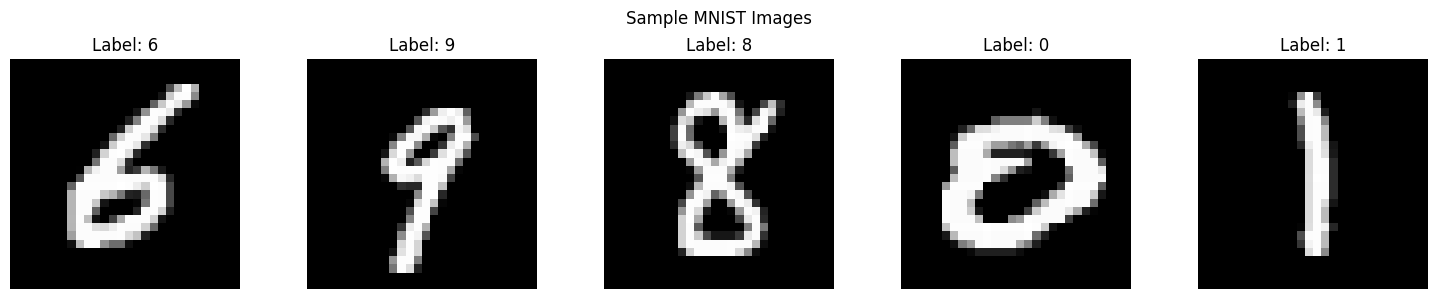

Number of Samples: 60000


In [43]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)


sample_indices = np.random.randint(0, len(mnist_dataset), size=5)
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle('Sample MNIST Images')
for i, idx in enumerate(sample_indices):
    image, label = mnist_dataset[idx]
    axs[i].imshow(image.squeeze(), cmap='gray')
    axs[i].set_title(f'Label: {label}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

images = torch.stack([img for img, _ in mnist_dataset])
labels = torch.tensor([label for _, label in mnist_dataset])

print(f"Number of Samples: {len(images)}")

### Building Your Neural Network to Classify Digits

Now, let's create our own neural network for the MNIST problem using PyTorch. For this problem, your network can have any number of layers and nodes, as long as it is set up for **classification** (not regression). 

Here are some core PyTorch components we recommend you use to build and train your model (click the hyper links to learn more about each component):

1. [**`nn.Module`**](https://pytorch.org/docs/stable/generated/torch.nn.Module.html): The base class for all neural network modules in PyTorch. By subclassing `nn.Module`, you can define and structure your own neural networks. Each layer of the network (like fully connected layers or activation functions) will be an attribute of this module, and the `forward()` method will define the data flow through these layers.

2. [**`nn.Linear`**](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html): This layer applies a linear transformation to the incoming data, making it useful for fully connected (dense) layers in a neural network.

3. [**`nn.Sigmoid`**](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html): A common activation function that maps input values to an output range of `[0, 1]`.

4. [**`nn.CrossEntropyLoss`**](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html): This is a loss function suited for classification tasks, especially where classes are mutually exclusive. `nn.CrossEntropyLoss` combines `log_softmax` and `nll_loss` in a single function, which makes it numerically more stable.

PyTorch offers a wide range of layers, activation functions, and loss functions for building neural networks, making it a flexible and powerful tool for experimentation. **While the components mentioned above are enough to complete this task, we encourage you to explore more.** There are many other layers, loss functions, and activation functions (some you've learned about, some new!) that may help you solve different types of problems or improve model performance.

Check out the full list of [PyTorch's Neural Network Layers and Loss Functions](https://pytorch.org/docs/stable/nn.html)!

In [44]:
# export - DO NOT MODIFY OR MOVE THIS LINE
# Initialize the layers, criterion, and model with classification objective
class MNISTNeuralNetwork(nn.Module):
    # Define the layers of the model that will be used in the forward pass
    def __init__(self, input_size: int, hidden_size: int, output_size: int) -> None:
        super(MNISTNeuralNetwork, self).__init__()
        ### YOUR CODE BELOW HERE ###
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.l3 = nn.Linear(hidden_size, output_size)
        ### YOUR CODE ABOVE HERE ###

    # Construct the forward pass using the defined layers and pass the input x through each layer
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ### YOUR CODE BELOW HERE ###
        x = self.flatten(x)
        x = self.relu(self.l1(x))
        x = self.relu2(self.l2(x))
        x = self.l3(x)
        ### YOUR CODE ABOVE HERE ###
        return x

### MNIST Hyperparameters

Set the following hyperparameters:
- `EPOCHS`: Number of times the entire training dataset is passed through the model. This should be a positive integer that is a multiple of 10. 
- `LR` (Learning Rate): Controls how much to adjust the model weights during training. This should be a positive float. 
- `BATCH_SIZE`: Number of samples processed before the model is updated. This should be a positive integer that that is a power of 2. 
- `EVAL_EVERY`: Frequency (in epochs) at which to evaluate the model on the validation set. This can be any positive integer. 
    
Feel free to experiment with different values to see how they affect training. We've put in placeholders as default values which might not be the best for your model, so feel free to change them.

In [45]:
# export - DO NOT MODIFY OR MOVE THIS LINE
def set_mnist_hyperparameters() -> None:
    '''
    Sets the hyperparameters for the MNIST model.
    '''
    global EPOCHS, LR, BATCH_SIZE, EVAL_EVERY
    
    ### YOUR CODE BELOW HERE ###
    EPOCHS = 20
    LR = 0.003
    BATCH_SIZE = 64
    EVAL_EVERY = 2
    ### YOUR CODE ABOVE HERE ###

In [46]:
set_mnist_hyperparameters()

### MNIST PyTorch Training Loop

Now that we have defined our PyTorch model, let’s set up a training loop to optimize the model parameters. This loop will look very similar to the MicroTorch training loop but with PyTorch-specific syntax.

**Key Components:**

1. **Optimizer**: PyTorch provides a variety of optimizers for updating model parameters based on computed gradients. Here, we will use `optim.SGD` for stochastic gradient descent. The optimizer is initialized with the model parameters and learning rate.
   - [PyTorch Documentation for `optim.SGD`](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)

2. **`.backward()`**: This method computes the gradient of the loss with respect to each parameter using backpropagation. PyTorch handles all gradient calculations automatically, so you don’t need to manually derive them as in MicroTorch.

3. **`.zero_grad()`**: Before each backward pass, we need to reset the gradients for each parameter by calling `optimizer.zero_grad()`. This ensures that gradients from previous steps don’t accumulate.

In [ ]:
# export - DO NOT MODIFY OR MOVE THIS LINE
def train_model_pytorch_mnist(images, labels, plot_losses=True):
    train_losses = []
    val_losses = []


    # Initialize model, loss, optimizer, and the set the hyperparameters
    ### YOUR CODE BELOW HERE ###
    input_size = 28*28  
    hidden_size = 128
    output_size = 10
    LR = 0.003
    BATCH_SIZE = 64
    EPOCHS = 20
    EVAL_EVERY = 2
    model = MNISTNeuralNetwork(input_size, hidden_size, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)
    ### YOUR CODE ABOVE HERE ###

    # Create DataLoaders
    images, labels = shuffle_data(images, labels)
    train_features, train_labels, test_features, test_labels = split_data(
        images, labels
    )
    train_loader = create_dataloader(train_features, train_labels, batch_size=BATCH_SIZE)
    test_loader = create_dataloader(test_features, test_labels, batch_size=BATCH_SIZE)

    for epoch in range(EPOCHS + 1):
        model.train()
        total_train_loss = 0
        """
        Implement the training loop steps:
        1. Forward pass through the model
        2. Calculate loss
        3. Zero gradients
        4. Backward pass
        5. Update parameters
        """
        for batch_features, batch_labels in train_loader:
            ### YOUR CODE BELOW HERE ###
            optimizer.zero_grad()
            loss = criterion(model(batch_features), batch_labels)
            loss.backward()
            optimizer.step()
            ### YOUR CODE ABOVE HERE ###
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluate on validation set every EVAL_EVERY epochs
        if epoch % EVAL_EVERY == 0:
            model.eval()
            total_val_loss = 0
            total_correct = 0

            """
            Implement the evaluation loop steps:
            1. Forward pass through the model (no need for gradients)
            2. Calculate loss
            3. Get predictions and compare with true labels
            """
            with torch.no_grad():
                for batch_features, batch_labels in test_loader:
                    ### YOUR CODE BELOW HERE ###
                    loss = criterion(model(batch_features), batch_labels)
                    total_val_loss += loss.item()
                    z, indices = torch.max(model(batch_features), dim=1)
                    total_correct += (indices == batch_labels).sum().item()
                    ### YOUR CODE ABOVE HERE ###

            avg_val_loss = total_val_loss / len(test_loader)
            accuracy = (total_correct / len(test_loader.dataset)) * 100
            val_losses.append(avg_val_loss)

            print(
                f"Epoch {epoch}/{EPOCHS} | "
                f"Train Loss: {avg_train_loss:.4f} | "
                f"Validation Loss: {avg_val_loss:.4f} | "
                f"Accuracy: {accuracy:.2f}%"
            )

            if plot_losses:
                plot_loss(
                    train_losses, val_losses, eval_interval=EVAL_EVERY, dynamic=True
                )

    print(
        f"Final Train Loss: {avg_train_loss:.4f} | "
        f"Final Validation Loss: {avg_val_loss:.4f} | "
        f"Final Accuracy: {accuracy:.2f}%"
    )
    if plot_losses:
        plot_loss(train_losses, val_losses, eval_interval=EVAL_EVERY, dynamic=False)
    return model, train_losses, val_losses

Final Train Loss: 0.0609 | Final Validation Loss: 0.1488 | Final Accuracy: 96.78%


<Figure size 640x480 with 0 Axes>

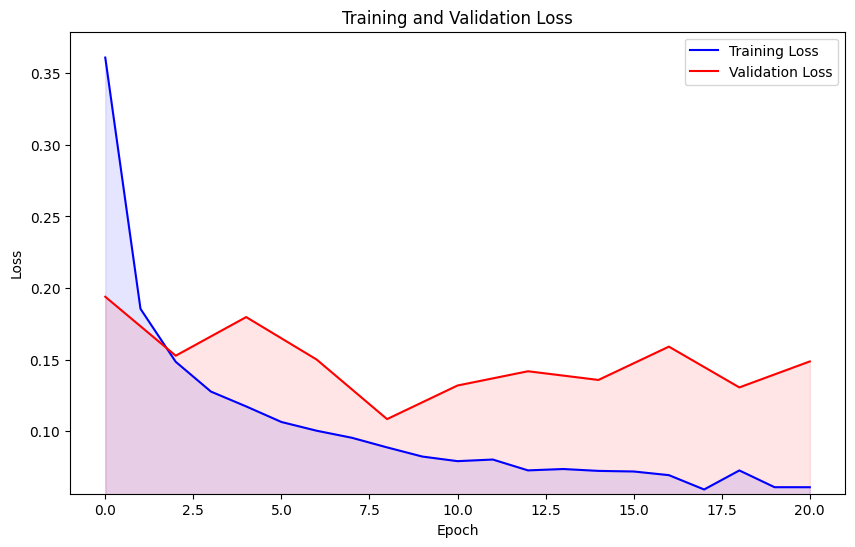

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [48]:
mnist_model, train_losses, val_losses = train_model_pytorch_mnist(images, labels, plot_losses=True)

**You should achieve an accuracy of above 95% in this portion.**

In [49]:
mnist_test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)
test_loader = DataLoader(mnist_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of test samples: {len(test_loader.dataset)}")

total_correct = 0
mnist_model.eval()

with torch.no_grad():
    for test_samples, test_labels in test_loader:
        test_outputs = mnist_model(test_samples)
        predicted_labels = torch.argmax(test_outputs, dim=1)
        total_correct += (predicted_labels == test_labels).sum().item()

accuracy = (total_correct / len(test_loader.dataset)) * 100
print(f'Accuracy: {accuracy:.2f}%')

Number of test samples: 10000
Accuracy: 96.86%


### Hand Drawing some MNIST Inputs

If you'd like to test your code further, we encourage you to draw some digits using the below cell. It will create a sketchpad for you to draw digits, and then it will use your trained model to predict the digit you drew.

Note that this will not be graded and is purely for your own exploration. Results may vary, as the images that you are creating are not exactly the same as the MNIST dataset. However, it should be a fun way to see how your model performs on new data!

In [50]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def predict_digit(image_dict: dict) -> str:
    '''
    Converts the input image to a tensor and predicts the digit.
    Returns the predicted digit as a string.
    '''
    image = image_dict["composite"]
        
    # Uncomment the below line to see the raw input image for debugging
    # Image.fromarray(image).save("raw_input.png")
    
    # RGBA images
    if image.shape[2] == 4:
        # Extract the alpha channel
        alpha = image[..., 3]
        
        # Create a mask where alpha > 0 (something's drawn here)
        mask = alpha > 0
        
        # For MNIST, we want black background (0) and white digits (255)
        result = np.zeros_like(alpha) # Black background
        result[mask] = 255 # Set drawn areas to white (255)
    else:
        # If RGB only, convert to grayscale
        gray = np.mean(image, axis=2).astype(np.uint8)
        result = gray
        
    # Convert to PIL and save/debug
    image_pil = Image.fromarray(result)

    # Uncomment the below line to see the processed image for debugging
    # image_pil.save("digit_debug.png")
    
    # Apply transforms
    digit = transform(image_pil).unsqueeze(0)
    
    # Save the tensor image for debugging
    transformed_image = digit.squeeze().numpy()
    
    # Properly reverse the normalization for visualization
    vis_img = ((transformed_image * 0.5 + 0.5) * 255).astype(np.uint8)

    # Uncomment the below line to see the input image for the model for debugging
    Image.fromarray(vis_img).save("model_input.png")

    mnist_model.eval()
    
    with torch.no_grad():
        output = mnist_model(digit)
        pred = output.argmax(dim=1).item()
    
    return f"Predicted Digit: {pred}"

app = gr.Interface(fn=predict_digit, inputs="sketchpad", outputs="text", live=False)
app.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [51]:
# run this to stop the app connection to the server in the notebook
app.close()

Closing server running on port: 7860


## Rig Juice Classification

When wandering the vast expanse of TextWorld, you've encountered a special power-up, courtesy of your good friend, Rigby: **RIG JUICE**. It's a strange, vibrant liquid that seems to have a mind of its own. It can be used to power up your search through TextWorld, but it also has a tendency to cause the agent to explode if it's unsafe. Luckily, you've been given a dataset with the characteristics of the different possible Rig Juice flavors (Rigby tends to invent new flavors on the fly). 


Rig juice is a juice that contains random items that Rigby finds, and since its conception, it has become a highly-valued substance in the TextWorld economy. Although little is known about the makeup of each jug of Rig juice found, they have unique ingredients and have been made with mysterious processes that make them highly sought after by explorers. For more information about Rig juice and its wondrous effects, [check out the following link](https://regularshow.fandom.com/wiki/Rig_Juice). 

Because they can be made with some wild ingredients, we need to make sure that the Rig juice that we're dealing with is safe. Many health experts in the TextWorld community have found poisonous jugs of Rig juice in the wild (Rigby's a careless guy sometimes). Our task is to use a neural network to determine whether a given jug of Rig juice is **poisonous** or **non-poisonous**, to ensure that our agent doesn't get injured in their journey. By training our neural network on this dataset, we want to achieve a high accuracy in a [binary classification](https://www.learndatasci.com/glossary/binary-classification/) of Rig juice. This will help improve our understanding the uniqueness of Rig juice to harness its utility to effectively search through TextWorld.  

### Setting up the Rig Juice Dataset and Neural Network

First, let's load the dataset and prepare the features and labels for training.

In [52]:
dataset = pd.read_csv("rig_juice_student.csv")
dataset.head(3)

,poisonous,radicola,fruit-punch,hot-sauce,sugar-bombs,frosted-flakes,apple,hard-candy,pickles,pickle-juice,...,drum-sticks,lawnmower-blade,garden-gnome,trophy,park-sign,telephone-cord,lost-sock,trampoline-spring,carnival-prize-fluff,coffee-coffee
0,0,1,1,1,0,1,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,1,1,1,1,1,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,1,1,1,1,1,1,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0


These are the dataset columns (features). 

In [53]:
print("Dataset columns:")
print(dataset.columns)

Dataset columns:
Index(['poisonous', 'radicola', 'fruit-punch', 'hot-sauce', 'sugar-bombs',
       'frosted-flakes', 'apple', 'hard-candy', 'pickles', 'pickle-juice',
       ...
       'drum-sticks', 'lawnmower-blade', 'garden-gnome', 'trophy', 'park-sign',
       'telephone-cord', 'lost-sock', 'trampoline-spring',
       'carnival-prize-fluff', 'coffee-coffee'],
      dtype='object', length=112)


The dataset contains various features (attributes; in this case, ingredients) of a sample of Rig Juice and a label indicating their class. The first column represents the label (class) which'll tell us whether something is poisonous or not, and the remaining columns are the features.

As we did before, we'll convert the data to [PyTorch tensors](https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html) for ease of use in our neural network.

In [54]:
# Convert the data to tensors
labels = torch.tensor(dataset["poisonous"].to_numpy(), dtype=torch.long)
features = torch.tensor(dataset.drop(columns = ["poisonous"]).to_numpy(), dtype=torch.float32)

print(f"Number of samples: {len(features)}")
print(f"Number of features: {features.shape[1]}")

Number of samples: 1625
Number of features: 111


Now, we'll define the neural network model for our binary classification task of the Rig juice dataset to determine whether samples of the Rig juice are poisonous or not. We'll use PyTorch's `nn.Module` class to create our model.

In [55]:
# export - DO NOT MODIFY OR MOVE THIS LINE
class RigJuiceNeuralNetwork(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int) -> None:
        super(RigJuiceNeuralNetwork, self).__init__()
        ### YOUR CODE BELOW HERE ###
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.l3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.l4 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        ### YOUR CODE ABOVE HERE ###

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ### YOUR CODE BELOW HERE ###
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu2(x)
        x = self.l3(x)
        x = self.relu3(x)
        x = self.l4(x)
        out = self.sigmoid(x)
        ### YOUR CODE ABOVE HERE ###
        return out

### Rig Juice Hyperparameters

Set the following hyperparameters:
- `EPOCHS`: Number of times the entire training dataset is passed through the model. This should be a positive integer that is a multiple of 10. 
- `LR` (Learning Rate): Controls how much to adjust the model weights during training. This should be a positive float. 
- `BATCH_SIZE`: Number of samples processed before the model is updated. This should be a positive integer that that is a power of 2. 
- `EVAL_EVERY`: Frequency (in epochs) at which to evaluate the model on the validation set. This can be any positive integer. 
    
Feel free to experiment with different values to see how they affect training. We've put in placeholders as default values which might not be the best for your model, so feel free to change them.

In [56]:
# export - DO NOT MODIFY OR MOVE THIS LINE
def set_rig_juice_hyperparameters() -> None:
    '''
    Sets the hyperparameters for the MNIST model.
    '''
    global EPOCHS, LR, BATCH_SIZE, EVAL_EVERY
    
    ### YOUR CODE BELOW HERE ###
    EPOCHS = 100
    LR = 0.005
    BATCH_SIZE = 64
    EVAL_EVERY = 10
    ### YOUR CODE ABOVE HERE ###

In [57]:
set_rig_juice_hyperparameters()

### Rig Juice Training Loop

Fill in the missing code to complete the training loop.

In [ ]:
# export - DO NOT MODIFY OR MOVE THIS LINE
def train_model_pytorch_rig_juice(features, labels, plot_losses=True):
    '''
    In this function, you will implement the training loop for the Rig Juice dataset.
    The training loop will include the following steps:
    - Initialize the model, loss function, and optimizer
    - Shuffle the data, split it into training and test sets
    - train the model using the training set 
        - for each batch in each epoch, perform the forward pass, calculate loss, zero gradients, and backward pass
    - Evaluate the model using the test set 
    - Plot the training and validation losses (if you wish)
    - Return the model, criterion, optimizer, training losses, validation losses, and test set
    '''
    # Initialize lists to store loss values
    train_losses = []
    val_losses = []

    # Initialize the model, loss, and optimizer, and set the hyperparameters
    # please name these respectively as `model`, `criterion`, and `optimizer`
    # YOUR CODE BELOW HERE
    input_size = features.shape[1]
    hidden_size = 128
    output_size = 2
    LR = 0.005
    BATCH_SIZE = 64
    EPOCHS = 100
    EVAL_EVERY = 10
    model = RigJuiceNeuralNetwork(input_size, hidden_size, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)
    # YOUR CODE ABOVE HERE

    # preparing the data
    features, labels = shuffle_data(features, labels)
    train_features, train_labels, test_features, test_labels = split_data(features, labels)
    train_loader = create_dataloader(train_features, train_labels, batch_size=BATCH_SIZE)

    for i in range(EPOCHS + 1):
        model.train()
        total_loss = 0
        for batch_features, batch_labels in train_loader:
            """
            Implement the training loop steps:
            1. Forward pass through the model
            2. Calculate loss
            3. Zero gradients
            4. Backward pass
            5. Update parameters
            """
            # YOUR CODE BELOW HERE
            optimizer.zero_grad()
            loss = criterion(model(batch_features), batch_labels)
            loss.backward()
            optimizer.step()
            # YOUR CODE ABOVE HERE
            total_loss += loss.item()

        loss = total_loss / len(train_loader)
        train_losses.append(loss)

        if i % EVAL_EVERY == 0:
            """
            Implement the evaluation loop steps:
            1. Forward pass through the model (no need for gradients)
            2. Calculate loss
            3. Get predictions and compare with true labels
            """
            # YOUR CODE BELOW HERE
            model.eval()
            with torch.no_grad():
                loss = criterion(model(test_features), test_labels)
            # YOUR CODE ABOVE HERE
            val_losses.append(loss.item())
            if plot_losses:
                plot_loss(train_losses, val_losses, eval_interval=EVAL_EVERY, dynamic=True)
 
    if plot_losses:
        plot_loss(train_losses, val_losses, eval_interval=EVAL_EVERY, dynamic=False)
    return model, criterion, optimizer, train_losses, val_losses, (test_features, test_labels)

<Figure size 640x480 with 0 Axes>

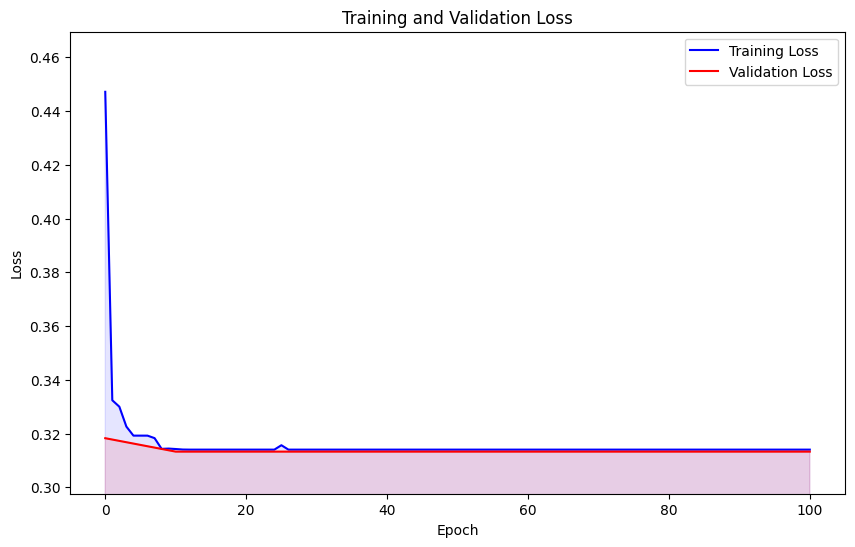

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [59]:
rig_juice_model, criterion, optimizer, train_losses, val_losses, test_data = train_model_pytorch_rig_juice(features, labels, plot_losses=True)

**You should achieve an accuracy of 95% in this portion.**

In [60]:
test_features, test_labels = test_data
predictions = rig_juice_model(test_features)
predictions = torch.argmax(predictions, dim=1)
accuracy = (predictions == test_labels).sum().item() / len(test_labels)
print("Accuracy: ", str(100 * accuracy) + "%")

Accuracy:  100.0%


# Grading

You score for this part of the assignment will be out of **50 points**. A more detailed breakdown is as follows: 
- 5 points will be towards implementing the data loading functions correctly. 
- 15 points will be towards implementing the MNIST network in PyTorch correctly (achieving 95% accuracy).
- 30 points will be towards implementing the Rig Juice network in PyTorch correctly (achieving 95% accuracy).

**There will be no hidden tests for the MNIST network or the data loading functions.** Your score for that portion of the assignment will be visible when submitting to Gradescope.

For the hidden tests for the Rig Juice dataset, we will use data from the same dataset provided (that is, you will not have to generalize your code to perform on a different dataset) that we have partitioned already. This is to ensure correctness of your implementation. The autograder will run a variety of tests for each section and assign scores, which will be visible after grades are published on Gradescope. 

# Submission
Upload this notebook with the name `submission.ipynb` file to Gradescope. The autograder will **only** run successfully if your file is named this way. You must ensure that you have removed all print statements from **your** code, or the autograder may fail to run. Excessive print statements will also result in muddled test case outputs, which makes it more difficult to interpret your score.

We've added appropriate comments to the top of certain cells for the autograder to export (`# export`). You do NOT have to do anything (e.g. remove print statements) to cells we have provided - anything related to those have been handled for you. You are responsible for ensuring your own code has no syntax errors or unnecessary print statements. You ***CANNOT*** modify the export comments at the top of the cells, or the autograder will fail to run on your submission.

You should ***not*** add any cells that your code requires to the notebook when submitting. You're welcome to add any code as you need to extra cells when testing, but they will not be graded. Only the provided cells will be graded. As mentioned in the top of the notebook, **any helper functions that you add should be nested within the function that uses them.**

If you encounter any issues with the autograder, please feel free to make a post on Ed Discussion. We highly recommend making a public post to clarify any questions, as it's likely that other students have the same questions as you! If you have a question that needs to be private, please make a private post.
